# Laboratory #06 : Face detection and recognition

At the end of this laboratory, you would get familiarized with

*   Face detection
    *   Integral images
    *   Haar-like feature computation
    *   Adaboost
*   Face recognition
    *   Eigen Faces
    *   PCA and LDA

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Use will have to mount your drive to access the images.

---

# **Students** (First Name and Last Name)

1.   Eva Veli
2.   Tatevik Davtyan

---

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import numpy as np
from skimage import data, io
import os
import matplotlib
from PIL import Image
from multiprocessing import Pool
from functools import partial
import time
import timeit
from matplotlib import pyplot as plt
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/MAI/CV/LAB 6/images/'

# Face Detection

## **Exercise #1:**

*   Build a function compute_integral_image that computes the integral image of an input (2D) array. In an integral image each pixel is the sum of all pixels in the original image that are 'left and above' the pixel. See the following example:

```
Original    Integral
+--------   +------------
| 1 2 3 .   | 0  0  0  0 .
| 4 5 6 .   | 0  1  3  6 .
| . . . .   | 0  5 12 21 .
            | . . . . . .
```

*   The integral image must have an additional row and column full of zeros (first row and first column).
*   Make sure that the values of the integral image are correct.
*   Plot the output of the integral image for the following array:

```
img_array = np.array([[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1],[1,2,2,2,1]])
```

In [ ]:
def compute_integral_image(img_arr ):
    """
    Calculates the integral image based on this instance's original image data.
    :param img_arr: Image source data
    :type img_arr: numpy.ndarray
    :return Integral image for given image
    :rtype: numpy.ndarray
    """
    # an index of -1 refers to the last row/column
    # since row_sum is calculated starting from (0,0),
    # rowSum(x, -1) == 0 holds for all x
    row_sum = np.zeros(img_arr.shape)
    # we need an additional column and row
    integral_image_arr = np.zeros((img_arr.shape[0] + 1, img_arr.shape[1] + 1))

    # Compute the integral image
    for i in range(img_arr.shape[0]):
        for j in range(img_arr.shape[1]):
            row_sum[i, j] = row_sum[i, j - 1] + img_arr[i, j]
            integral_image_arr[i + 1, j + 1] = integral_image_arr[i, j + 1] + row_sum[i, j]

    return integral_image_arr

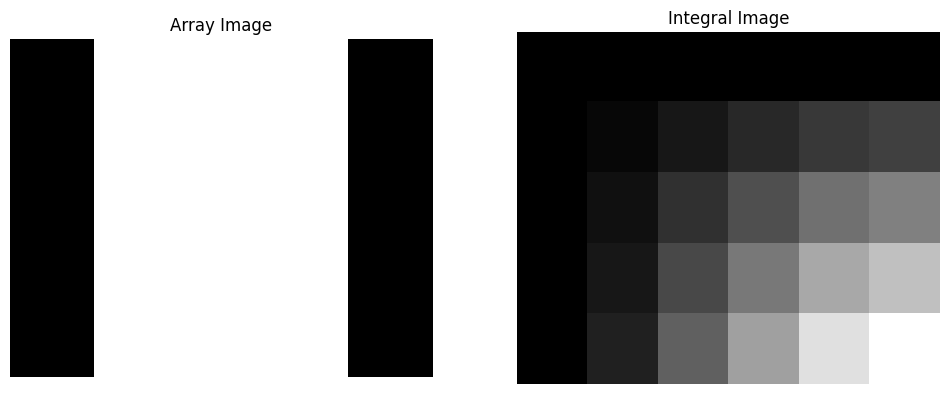

In [ ]:
img_array = np.array([[1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1], [1, 2, 2, 2, 1]])
# Compute the integral image
integral_image = compute_integral_image(img_array)

# Plot the original and integral images
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title("Array Image")
axes[0].axis('off')

axes[1].imshow(integral_image, cmap='gray')
axes[1].set_title("Integral Image")
axes[1].axis('off')

plt.show()


In [ ]:
ii_img_array = compute_integral_image(img_array)
print("Original image:")
print(img_array)
print("Integral image:")
print(ii_img_array)

Original image:
[[1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]
 [1 2 2 2 1]]
Integral image:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  1.  3.  5.  7.  8.]
 [ 0.  2.  6. 10. 14. 16.]
 [ 0.  3.  9. 15. 21. 24.]
 [ 0.  4. 12. 20. 28. 32.]]


*   Test the function using 'camera' image from the data module. Plot the original image and the integral image.

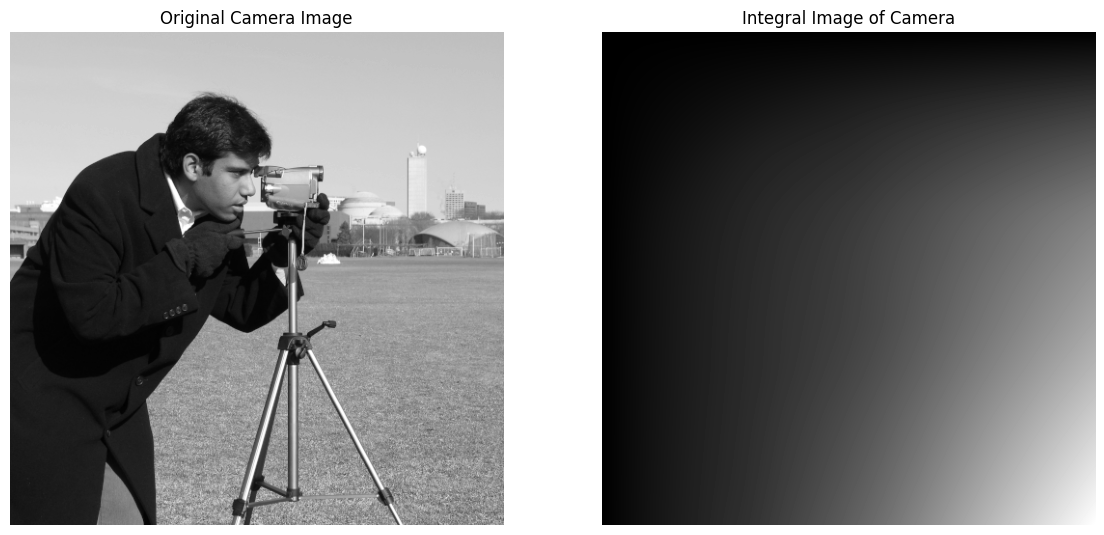

In [ ]:
# solution
camera_image = data.camera()
camera_integral_image = compute_integral_image(camera_image)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes[0].imshow(camera_image, cmap='gray')
axes[0].set_title("Original Camera Image")
axes[0].axis('off')

axes[1].imshow(camera_integral_image, cmap='gray')
axes[1].set_title("Integral Image of Camera")
axes[1].axis('off')

plt.show()

## **Exercise #2:**

*   Create a function sum_region to compute the sum of the pixel intensities within a rectangle using the integral image. The rectangle will be defined using the top left (x, y) and bottom right (x, y) coordinates.

In [ ]:
def sum_region(integral_img_arr, top_left, bottom_right):
  #Code to complete
  top_right   = [top_left[0], bottom_right[1]]
  bottom_left = [bottom_right[0], top_left[1]]

  sum_top_left     = integral_img_arr[top_left[0],top_left[1]]
  sum_top_right    = integral_img_arr[top_right[0],top_right[1]]
  sum_bottom_left  = integral_img_arr[bottom_left[0],bottom_left[1]]
  sum_bottom_right = integral_img_arr[bottom_right[0],bottom_right[1]]

  return sum_top_left+sum_bottom_right-(sum_top_right+sum_bottom_left)

*   Make the following tests:

In [ ]:
# result you should get (12)
sum_region(ii_img_array, [1, 1], [3, 4])

12.0

In [ ]:
# result you should get (32)
sum_region(ii_img_array, [0, 0], [-1, -1])

32.0

## **Exercise #3:**

*   Build a function load_integral_images to read all the images inside a given folder and compute the integral image of every image

In [ ]:
def load_integral_images(path):
    ii_images = []
    for _file in os.listdir(path):

        #### Read image
        image = io.imread(path+_file, as_gray=True)
        integral_image = compute_integral_image(image)

        #### Remember to scale the images (with the max pixel intensity value)
        integral_image /= np.max(integral_image)

        ii_images.append(integral_image)

    return ii_images
# With this function we are reading each file in the folder, calculating its integral image and after that normalizing the image.
# Finally we put our processed image in the list that we will return

In [ ]:
pos_training_path = os.path.join(path, 'train_data/faces/')
neg_training_path = os.path.join(path, 'train_data/non_faces/')
pos_testing_path  = os.path.join(path, 'test_data/faces/')
neg_testing_path  = os.path.join(path, 'test_data/non_faces/')

In [ ]:
pos_training = load_integral_images(pos_training_path)
neg_training = load_integral_images(neg_training_path)
pos_testing = load_integral_images(pos_testing_path)
neg_testing = load_integral_images(neg_testing_path)

<ipython-input-14-c7a34eb5430c>:10: RuntimeWarning: invalid value encountered in divide
  integral_image /= np.max(integral_image)


*   Visualize a few original images and the corresponding integral images using matplotlib.

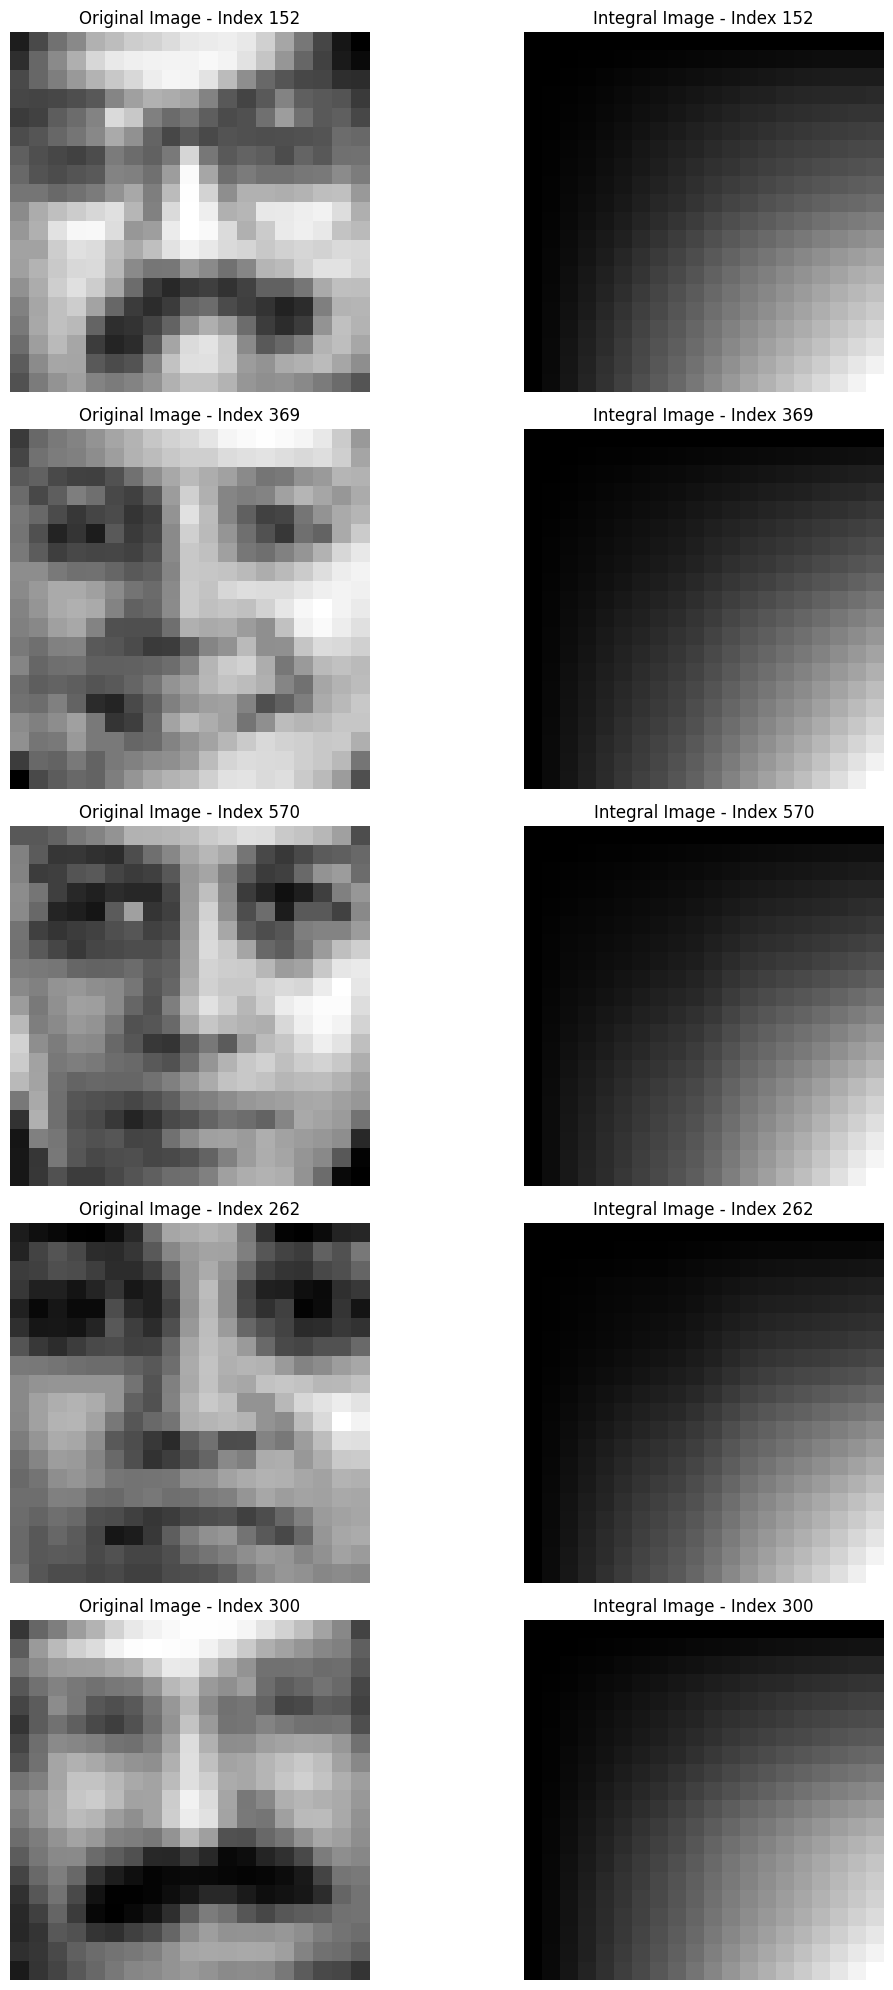

In [ ]:
posTrainFiles = os.listdir(pos_training_path)
indexs = np.random.randint(0,len(posTrainFiles)-1,5)

fig, axes = plt.subplots(5, 2, figsize=(12, 20))

for idx, ax_row in zip(indexs, axes):
    image = io.imread(pos_training_path+posTrainFiles[idx], as_gray=True)
    integral_image = pos_training[idx]

    # Display the original image
    ax_row[0].imshow(image, cmap='gray')
    ax_row[0].set_title(f"Original Image - Index {idx}")
    ax_row[0].axis('off')

    # Display the integral image
    ax_row[1].imshow(integral_image, cmap='gray')
    ax_row[1].set_title(f"Integral Image - Index {idx}")
    ax_row[1].axis('off')

plt.tight_layout()
plt.show()

## **Exercise #4:**

*   Compute the Haar features of an image.
*   We provide you with HaarLikeFeature class that has build in a get_score function and a get_vote function. Your job is to complete the code of the method _create_features in the class HaarLikeFeature:

In [ ]:
def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')

    t0 = time.time()

    features = []

    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                # Loop over possible x values and y values
                # - For each (x,y) create the HarrLikeFeature objects.
                # - append the HaarlikeFeatures in the features list.
                # Notice that Haarlike features contain polarity, append features for polarity 1 and -1
                # The threshold can be set to 0 for all of them.

                for x in range(img_height-feature_height-1):
                    for y in range(img_width-feature_width-1):
                      harr_feature_positive = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0,  1)
                      features.append(harr_feature_positive)
                      harr_feature_negative = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, -1)
                      features.append(harr_feature_negative)


    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)

    return features

In [ ]:
def enum(**enums):
    return type('Enum', (), enums)

FeatureType = enum(TWO_VERTICAL=(1, 2), TWO_HORIZONTAL=(2, 1), THREE_HORIZONTAL=(3, 1), THREE_VERTICAL=(1, 3), FOUR=(2, 2))
FeatureTypes = [FeatureType.TWO_VERTICAL, FeatureType.TWO_HORIZONTAL, FeatureType.THREE_VERTICAL, FeatureType.THREE_HORIZONTAL, FeatureType.FOUR]

In [ ]:
class HaarLikeFeature(object):
    """
    Class representing a haar-like feature.
    """

    def __init__(self, feature_type, position, width, height, threshold, polarity):
        """
        Creates a new haar-like feature.
        :param feature_type: Type of new feature, see FeatureType enum
        :type feature_type: HaarLikeFeature.FeatureTypes
        :param position: Top left corner where the feature begins (x, y)
        :type position: (int, int)
        :param width: Width of the feature
        :type width: int
        :param height: Height of the feature
        :type height: int
        :param threshold: Feature threshold
        :type threshold: float
        :param polarity: polarity of the feature -1 or 1
        :type polarity: int
        """
        self.type = feature_type
        self.top_left = position
        self.bottom_right = (position[0] + width, position[1] + height)
        self.width = width
        self.height = height
        self.threshold = threshold
        self.polarity = polarity
        self.weight = 1

    def get_score(self, int_img):
        """
        Get score for given integral image array.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: Score for given feature
        :rtype: float
        """
        score = 0
        if self.type == FeatureType.TWO_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.top_left[0] + self.width, int(self.top_left[1] + self.height / 2)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.TWO_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), self.bottom_right)
            score = first - second
        elif self.type == FeatureType.THREE_HORIZONTAL:
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 3), self.top_left[1] + self.height))
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 3), self.top_left[1]), (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1] + self.height))
            third = sum_region(int_img, (int(self.top_left[0] + 2 * self.width / 3), self.top_left[1]), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.THREE_VERTICAL:
            first = sum_region(int_img, self.top_left, (self.bottom_right[0], int(self.top_left[1] + self.height / 3)))
            second = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 3)), (self.bottom_right[0], int(self.top_left[1] + 2 * self.height / 3)))
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + 2 * self.height / 3)), self.bottom_right)
            score = first - second + third
        elif self.type == FeatureType.FOUR:
            # top left area
            first = sum_region(int_img, self.top_left, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)))
            # top right area
            second = sum_region(int_img, (int(self.top_left[0] + self.width / 2), self.top_left[1]), (self.bottom_right[0], int(self.top_left[1] + self.height / 2)))
            # bottom left area
            third = sum_region(int_img, (self.top_left[0], int(self.top_left[1] + self.height / 2)), (int(self.top_left[0] + self.width / 2), self.bottom_right[1]))
            # bottom right area
            fourth = sum_region(int_img, (int(self.top_left[0] + self.width / 2), int(self.top_left[1] + self.height / 2)), self.bottom_right)
            score = first - second - third + fourth
        return score

    def get_vote(self, int_img):
        """
        Get vote of this feature for given integral image.
        :param int_img: Integral image array
        :type int_img: numpy.ndarray

        :return: 1 iff this feature votes positively, otherwise -1
        :rtype: int
        """
        score = self.get_score(int_img)
        return self.weight * (1 if score < self.polarity * self.threshold else -1)

In [ ]:
def learn(positive_iis, negative_iis, num_classifiers=-1, min_feature_width=1, max_feature_width=-1, min_feature_height=1, max_feature_height=-1):
    """
    Selects a set of classifiers. Iteratively takes the best classifiers based
    on a weighted error.
    :param positive_iis: List of positive integral image examples
    :type positive_iis: list[numpy.ndarray]
    :param negative_iis: List of negative integral image examples
    :type negative_iis: list[numpy.ndarray]
    :param num_classifiers: Number of classifiers to select, -1 will use all
    classifiers
    :type num_classifiers: int

    :return: List of selected features
    :rtype: list[HaarLikeFeature.HaarLikeFeature]
    """
    num_pos = len(positive_iis)
    num_neg = len(negative_iis)
    num_imgs = num_pos + num_neg
    img_height, img_width = positive_iis[0].shape

    # Maximum feature width and height default to image width and height
    max_feature_height = img_height if max_feature_height == -1 else max_feature_height
    max_feature_width = img_width if max_feature_width == -1 else max_feature_width

    # Create initial weights and labels
    pos_weights = np.ones(num_pos) * 1. / (2 * num_pos)
    neg_weights = np.ones(num_neg) * 1. / (2 * num_neg)
    weights = np.hstack((pos_weights, neg_weights))
    labels = np.hstack((np.ones(num_pos), np.ones(num_neg) * -1))

    images = positive_iis + negative_iis

    # Create features for all sizes and locations
    features = _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height)
    num_features = len(features)
    feature_indexes = list(range(num_features))

    num_classifiers = num_features if num_classifiers == -1 else num_classifiers

    print('Calculating scores for images..')
    t0 = time.time()
    votes = np.zeros((num_imgs, num_features))
    # Use as many workers as there are CPUs
    pool = Pool(processes=8)
    for i in range(num_imgs):
        votes[i, :] = np.array(list(pool.map(partial(_get_feature_vote, image=images[i]), features)))


    print('\tTime needed for calculating scores:', time.time()-t0)

    # select classifiers
    classifiers = []

    t0 = time.time()
    print('Selecting classifiers..')
    for _ in range(num_classifiers):

        classification_errors = np.zeros(len(feature_indexes))

        # normalize weights
        weights *= 1. / np.sum(weights)

        # select best classifier based on the weighted error
        for f in range(len(feature_indexes)):
            f_idx = feature_indexes[f]
            # classifier error is the sum of image weights where the classifier
            # is right
            error = sum(map(lambda img_idx: weights[img_idx] if labels[img_idx] != votes[img_idx, f_idx] else 0, range(num_imgs)))
            classification_errors[f] = error

        # get best feature, i.e. with smallest error
        min_error_idx = np.argmin(classification_errors)
        best_error = classification_errors[min_error_idx]
        best_feature_idx = feature_indexes[min_error_idx]

        # set feature weight
        best_feature = features[best_feature_idx]
        feature_weight = 0.5 * np.log((1 - best_error) / best_error)
        best_feature.weight = feature_weight

        classifiers.append(best_feature)

        # update image weights
        weights = np.array(list(map(lambda img_idx: weights[img_idx] * np.sqrt((1-best_error)/best_error) if labels[img_idx] != votes[img_idx, best_feature_idx] else weights[img_idx] * np.sqrt(best_error/(1-best_error)), range(num_imgs))))

        # remove feature (a feature can't be selected twice)
        feature_indexes.remove(best_feature_idx)

    print('\tTime needed for Selecting Classifiers:', time.time()-t0,'\n')

    return classifiers


def _get_feature_vote(feature, image):
    return feature.get_vote(image)


def _create_features(img_height, img_width, min_feature_width, max_feature_width, min_feature_height, max_feature_height):
    print('Creating Haar-like features..')
    t0 = time.time()
    features = []
    for feature in FeatureTypes:
        # FeatureTypes are just tuples
        feature_start_width = max(min_feature_width, feature[0])
        for feature_width in range(feature_start_width, max_feature_width, feature[0]):
            feature_start_height = max(min_feature_height, feature[1])
            for feature_height in range(feature_start_height, max_feature_height, feature[1]):
                ########################
                ### FILL IN HERE
                ########################
                for x in range(img_height-feature_height-1):
                    for y in range(img_width-feature_width-1):
                      harr_feature_positive = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0,  1)
                      features.append(harr_feature_positive)
                      harr_feature_negative = HaarLikeFeature(feature, (x,y), feature_width, feature_height, 0, -1)
                      features.append(harr_feature_negative)

    print('\t' + str(len(features)) + ' features created.')
    print('\tTime needed for calculating Harr-like features:', time.time()-t0)
    return features

## **Exercise #5:**

*   Use the learn method to learn a list of two classifiers with the train data. With the learn function you can build a list of classifiers that detect whether an image contains a face or not.

*   Use the following hyperparameters of the features and num_classifiers

In [ ]:
num_classifiers = 2
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time
classifiers = learn(pos_training, neg_training, num_classifiers=num_classifiers,
                    min_feature_width=min_feature_width, max_feature_width=max_feature_width,
                    min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2090 features created.
	Time needed for calculating Harr-like features: 0.012468576431274414
Calculating scores for images..
	Time needed for calculating scores: 395.5942726135254
Selecting classifiers..
	Time needed for Selecting Classifiers: 40.2750358581543 

CPU times: user 3min 31s, sys: 16.7 s, total: 3min 48s
Wall time: 7min 16s


## **Exercise #6:**

*   Make a function for voting with different classifiers
*   Build two functions ensemble_vote and ensemble_vote_all.
*   **ensemble_vote(int_img, classifiers)** has to return a 1 if the majority of the votes of the classifiers is positive and a zero otherwise
*   **ensemble_vote_all(int_imgs, classifiers)** has to loop over the list int_imgs and compute the ensemble_vote for each image in the list. It has to return a list containing all the votes for all the images in int_imgs.


In [ ]:
# solution
def ensemble_vote(int_img, classifiers):
  majorityThreshold = math.floor(len(classifiers)/2+1)
  for classifier in classifiers:
    majorityThreshold -= (classifier.get_vote(int_img) > 0)
    if majorityThreshold == 0: return 1
  return 0

def ensemble_vote_all(int_imgs, classifiers):
  votes = []
  for int_img in int_imgs:
    vote = ensemble_vote(int_img, classifiers)
    votes.append(vote)
  return np.array(votes)

pos_training_votes = ensemble_vote_all(pos_training, classifiers)
neg_training_votes = ensemble_vote_all(neg_training, classifiers)
pos_testing_votes  = ensemble_vote_all(pos_testing, classifiers)
neg_testing_votes  = ensemble_vote_all(neg_testing, classifiers)

*   Use the functions to compute the train and test acurracies for faces and non faces.
*   Print the results in the following format:

```
train results:
Correctly identified Faces: 2129/2429  (87.64923836969946%)
Correctly identified non-Faces: 4276/8548  (50.02339728591484%)

test results:
Correctly identified Faces: 300/472  (63.559322033898304%)
Correctly identified non-Faces: 74/128  (57.8125%)
```

*   It is not required to get this exact results but print the information in this format. It facilitates understanding the results.

In [ ]:
def print_results(pos_training_votes, neg_training_votes, pos_testing_votes, neg_testing_votes, roundValue=8, returnPercentages=False):
    # Training set statistics
    total_pos_train = len(pos_training_votes)
    correct_pos_train = np.sum(pos_training_votes)
    percentage_correct_pos_train = 100 * correct_pos_train / total_pos_train

    total_neg_train = len(neg_training_votes)
    incorrect_neg_train = np.sum(neg_training_votes)
    correct_neg_train = total_neg_train - incorrect_neg_train
    percentage_correct_neg_train = 100 * correct_neg_train / total_neg_train

    # Testing set statistics
    total_pos_test = len(pos_testing_votes)
    correct_pos_test = np.sum(pos_testing_votes)
    percentage_correct_pos_test = 100 * correct_pos_test / total_pos_test

    total_neg_test = len(neg_testing_votes)
    incorrect_neg_test = np.sum(neg_testing_votes)
    correct_neg_test = total_neg_test - incorrect_neg_test
    percentage_correct_neg_test = 100 * correct_neg_test / total_neg_test

    # Print the results
    print("train results:")
    print(f"Correctly identified Faces: {correct_pos_train}/{total_pos_train} ({percentage_correct_pos_train:.8f}%)")
    print(f"Correctly identified non-Faces: {correct_neg_train}/{total_neg_train} ({percentage_correct_neg_train:.8f}%)")
    print()
    print("test results:")
    print(f"Correctly identified Faces: {correct_pos_test}/{total_pos_test} ({percentage_correct_pos_test:.8f}%)")
    print(f"Correctly identified non-Faces: {correct_neg_test}/{total_neg_test} ({percentage_correct_neg_test:.8f}%)")


    if returnPercentages:
        return (
            round(percentage_correct_pos_train, roundValue),
            round(percentage_correct_neg_train, roundValue),
            round(percentage_correct_pos_test, roundValue),
            round(percentage_correct_neg_test, roundValue),
        )

print_results(pos_training_votes, neg_training_votes, pos_testing_votes, neg_testing_votes)

train results:
Correctly identified Faces: 2069/2429 (85.17908604%)
Correctly identified non-Faces: 6139/8555 (71.75920514%)

test results:
Correctly identified Faces: 254/472 (53.81355932%)
Correctly identified non-Faces: 97/128 (75.78125000%)


## **Exercise #7:**

*   Make another test with 20 classifiers instead of 2.
*   Inspect the classification results if you use adaboost with 20 classifiers. *   Use the same hyperameters for the features. Print the results as in the previous exercise.

In [ ]:
num_classifiers = 20
min_feature_height = 8
max_feature_height = 10
min_feature_width = 8
max_feature_width = 10

In [ ]:
%%time
classifiers_20 = learn(pos_training, neg_training, num_classifiers=num_classifiers,
                       min_feature_width=min_feature_width, max_feature_width=max_feature_width,
                       min_feature_height=min_feature_height, max_feature_height=max_feature_height)

Creating Haar-like features..
	2090 features created.
	Time needed for calculating Harr-like features: 0.008028507232666016
Calculating scores for images..
	Time needed for calculating scores: 430.52860164642334
Selecting classifiers..
	Time needed for Selecting Classifiers: 404.9383797645569 

CPU times: user 9min 39s, sys: 18 s, total: 9min 57s
Wall time: 13min 55s


In [ ]:
pos_training_votes_20 = ensemble_vote_all(pos_training, classifiers_20)
neg_training_votes_20 = ensemble_vote_all(neg_training, classifiers_20)
pos_testing_votes_20 = ensemble_vote_all(pos_testing, classifiers_20)
neg_testing_votes_20 = ensemble_vote_all(neg_testing, classifiers_20)

print_results(pos_training_votes_20, neg_training_votes_20, pos_testing_votes_20, neg_testing_votes_20)

train results:
Correctly identified Faces: 1902/2429 (78.30382874%)
Correctly identified non-Faces: 7754/8555 (90.63705435%)

test results:
Correctly identified Faces: 186/472 (39.40677966%)
Correctly identified non-Faces: 117/128 (91.40625000%)


*   Discuss if the classification results improved in the train data.


**Solution**

From the results it is obvious that 2 classsifier model is better at recognizing faces, while the 20 classifier model performs better at identifying non-faces. For identifying faces, using only 2 classifiers, we achived an accuracy rate of 85%, while with the other, it dropped to 78%. For identifying non-faces we can see that the accuracy rate of non-faces improves significantly to 90% with 20 classifiers, while with 2 classifier is much lower, 71%.

A similar trend is seen in the test set. This difference could be due to the challenge of reaching consensus among a larger number of classifiers (with 20 classifiers, at least 10 need to agree on a positive decision), whereas it is easier to reach agreement when only 2 classifiers are used. This outcome might also suggest overfitting or could be influenced by the imbalance in the training dataset (2,429 faces vs 8,555 non-faces).

## **Exercise #8:**

*   Change the voting functions so that you can set a threshold for deciding a prediction.
*   The threshold value indicates the minimum score for assigning a "positive" label (detect a face).
*   Create the following functions
    *   ensemble_vote_t: returns the final decision of a list of classifiers for a given threshold.
    *   ensemble_vote_all_t: Iterates over a list of integral images and returns the final decision of a list of classifiers for each of the images (for a given threshold).

In [ ]:
def ensemble_vote_t(int_img, classifiers, threshold):
  votes = 0
  for classifier in classifiers:
    votes += classifier.get_vote(int_img)

  return int(votes > threshold)

def ensemble_vote_all_t(int_imgs, classifiers, threshold):
  votes = []
  for int_img in int_imgs:
    vote = ensemble_vote_t(int_img, classifiers, threshold)
    votes.append(vote)
  return np.array(votes)


*   Using the list of 20 classifiers compute the following:

    1.   number of correct faces over all faces (in the train data)
    2.   number of correct non faces over all non faces (in the train data)
    3.   number of correct faces over all faces (in the test data)
    4.   number of correct non faces over all non faces (in the test data)

*   The quantities have to be computed for each of the following thresholds:
```
thresholds = np.array([x for x in range(-5,5,1)])/10.
```

In [ ]:
# solution
thresholds = np.array([x for x in range(-5,5,1)])/10
correct_pos_trains = []
correct_neg_trains = []
correct_pos_tests = []
correct_neg_tests = []

for threshold in thresholds:
    print(f"Threshold: {threshold}")

    votes_data = [
        ("pos_training", pos_training),
        ("neg_training", neg_training),
        ("pos_testing", pos_testing),
        ("neg_testing", neg_testing),
    ]

    results = {}
    for key, data in votes_data:
        results[key] = ensemble_vote_all_t(data, classifiers_20, threshold)

    # Compute correct classifications and append to lists
    correct_pos_train, correct_neg_train, correct_pos_test, correct_neg_test = print_results(
        results["pos_training"], results["neg_training"],
        results["pos_testing"], results["neg_testing"],
        returnPercentages=True
    )

    correct_pos_trains.append(correct_pos_train)
    correct_neg_trains.append(correct_neg_train)
    correct_pos_tests.append(correct_pos_test)
    correct_neg_tests.append(correct_neg_test)

print("\n")

Threshold: -0.5
train results:
Correctly identified Faces: 2356/2429 (96.99464800%)
Correctly identified non-Faces: 5955/8555 (69.60841613%)

test results:
Correctly identified Faces: 345/472 (73.09322034%)
Correctly identified non-Faces: 90/128 (70.31250000%)
Threshold: -0.4
train results:
Correctly identified Faces: 2317/2429 (95.38904899%)
Correctly identified non-Faces: 6268/8555 (73.26709527%)

test results:
Correctly identified Faces: 328/472 (69.49152542%)
Correctly identified non-Faces: 94/128 (73.43750000%)
Threshold: -0.3
train results:
Correctly identified Faces: 2307/2429 (94.97735694%)
Correctly identified non-Faces: 6496/8555 (75.93220339%)

test results:
Correctly identified Faces: 314/472 (66.52542373%)
Correctly identified non-Faces: 96/128 (75.00000000%)
Threshold: -0.2
train results:
Correctly identified Faces: 2265/2429 (93.24825031%)
Correctly identified non-Faces: 6778/8555 (79.22852133%)

test results:
Correctly identified Faces: 292/472 (61.86440678%)
Correctly 

*   Make a bar plot for 1-4. In the x axis write the threshold value.

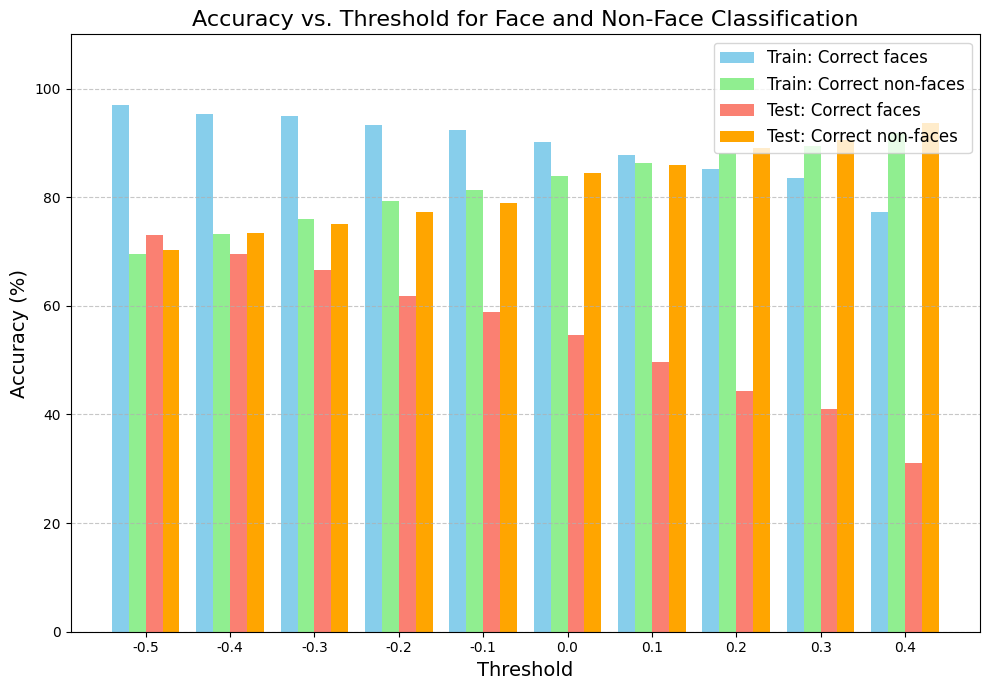

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

width = 0.02
positions = [thresholds, thresholds + width, thresholds + width * 2, thresholds + width * 3]

ax.bar(positions[0], correct_pos_trains, width, color='skyblue', label="Train: Correct faces")
ax.bar(positions[1], correct_neg_trains, width, color='lightgreen', label="Train: Correct non-faces")
ax.bar(positions[2], correct_pos_tests, width, color='salmon', label="Test: Correct faces")
ax.bar(positions[3], correct_neg_tests, width, color='orange', label="Test: Correct non-faces")

ax.set_ylim(0, 110)
ax.set_xlabel("Threshold", fontsize=14)
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_xticks(thresholds + width * 1.5)
ax.set_xticklabels([f"{t:.1f}" for t in thresholds])
ax.set_title("Accuracy vs. Threshold for Face and Non-Face Classification", fontsize=16)
ax.grid(axis='y', linestyle='--', alpha=0.7)


ax.legend(loc='upper right', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


*   Discuss what happens when you increase the threshold value.

**Solution**

The threshold can be seen as a parameter that helps adjust the model's performance by emphasizing either fewer false negatives or fewer false positives. This ability to fine-tune the model's behavior can be very beneficial in real-world scenarios.

So to conclude, increasing the threshold leads to a model that excels at identifying non-faces but performs poorly at detecting faces. On the other hand, lowering the threshold results in a model that is better at detecting faces but becomes less accurate at identifying non-faces.

...

# Face Recognition

In [ ]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [ ]:
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# introspect the images arrays to find the shapes
n_samples, h, w = lfw_people.images.shape

# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [ ]:
# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction

n_components = 100

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)

print("done in %0.3fs" % (time() - t0))

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 966 faces
done in 0.546s


In [ ]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.042s


In [ ]:
# Train a SVM classification model

print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                   param_grid, cv=5)
clf = clf.fit(X_train_pca, y_train)

print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 24.296s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.005)


In [ ]:
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()

y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.036s


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.69      0.72        13
     Colin Powell       0.79      0.92      0.85        60
  Donald Rumsfeld       0.77      0.63      0.69        27
    George W Bush       0.89      0.95      0.92       146
Gerhard Schroeder       0.83      0.76      0.79        25
      Hugo Chavez       0.90      0.60      0.72        15
       Tony Blair       0.86      0.69      0.77        36

         accuracy                           0.85       322
        macro avg       0.83      0.75      0.78       322
     weighted avg       0.85      0.85      0.84       322



In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   0   3   1   0   0   0]
 [  0  55   0   4   0   1   0]
 [  2   3  17   5   0   0   0]
 [  0   5   1 139   0   0   1]
 [  0   1   0   3  19   0   2]
 [  0   3   0   0   2   9   1]
 [  1   3   1   4   2   0  25]]


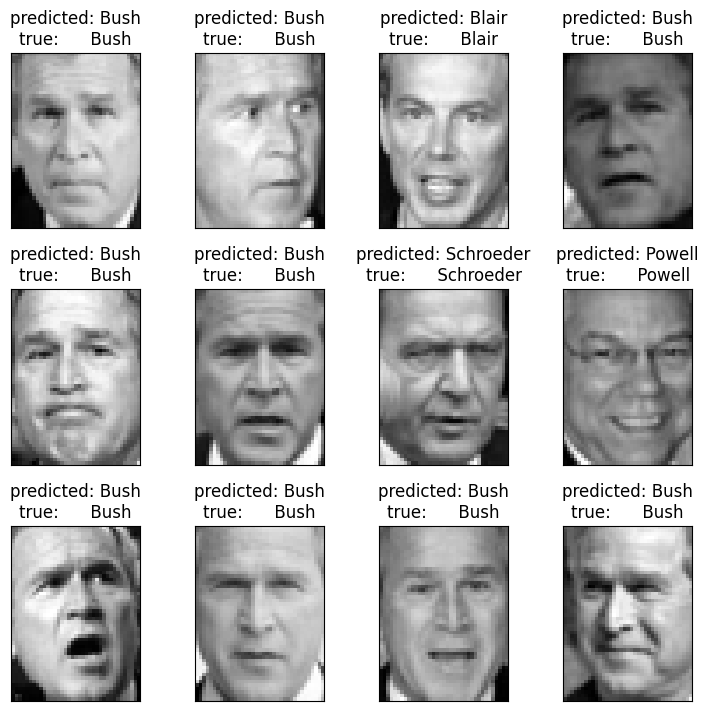

In [ ]:
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

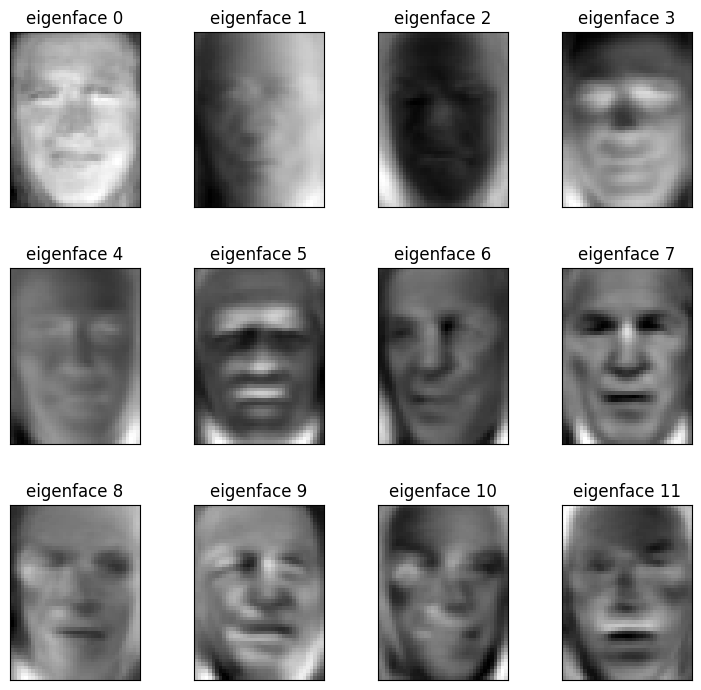

In [ ]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

plt.show()

## **Exercise #1:**

*   Show the total percentage of variance explained by the selected components of the PCA.


In [ ]:
# solution
explained_variance = np.sum(pca.explained_variance_ratio_) * 100

# Print the result
print(f"Total percentage of variance explained by the selected components of the PCA: {explained_variance:.5f}%")


Total percentage of variance explained by the selected components of the PCA: 91.53858%


## **Exercise #2:**

*   Explain all the measures showed in the classification report.
*   Discuss the obtained classification results, the quantitative as well as the qualitative results.
*   Comment the showed eigenfaces.



**Solution**

* Explanation of the measures
   - Precision measures the proportion of true positives (correctly predicted samples) among all samples predicted as that class.
   - Recall measures the proportion of true positives among all actual samples of that class.
   - The F1-score is the harmonic mean of precision and recall, providing a single measure of model performance that balances both metrics.
   - Support is the number of actual occurrences of each class in the test dataset.
   - Accuracy is the overall proportion of correctly predicted samples across all classes.
   - The macro average calculates the mean of precision, recall, and F1-score across all classes, giving equal weight to each class.It does not take into account class imbalance.
   - The weighted average takes into account the support (number of samples) for each class, giving more weight to classes with more samples. It accounts for class imbalance.
   
* Classification Results

  - The model achieved an accuracy of 85%, which indicates strong performance. The precision scores are mostly high across classes, suggesting that the model makes accurate predictions when it identifies a specific individual. For example, George W Bush had a precision of 0.89, meaning that when the model predicted "Bush," it was correct 89% of the time. Recall scores vary more significantly. Colin Powell had the highest recall (0.92), indicating that the model was effective at identifying most samples of this class. However, the recall for Hugo Chavez was lower (0.60), suggesting the model struggled to recognize this class consistently. The macro average F1-score is 0.78, which is lower than the weighted average of 0.84. This difference indicates the presence of class imbalance in the dataset, the model performs better on well-represented classes, which are given more weight in the weighted average calculation. The confusion matrix reveals specific misclassification patterns. For instance, George W Bush was often confused with Colin Powell, maybe due to similar facial features or image conditions. There is also some confusion happening with Donald Rumsfeld and also with Tony Blair, meaning that there is a difficulty in distinguishing between certain individuals.
  
   In the qualitative results we can observe that all the predictions are all correct, indicating that the model has learned to recognize this individual well. Since George W Bush has the most number of samples in the dataset, we can see him appear more, aligning with the confusion matrix, where George W Bush has fewer false positives and false negatives.

* Comment eigenfaces

  - As we know from theory, the showed eigenfaces represent the principal components from PCA applied to the face dataset. They capture the main features and variations in facial structure. As we can see from the results, they look like ghost-like images, highlighting common facial features such as eyes, nose, and mouth. The first few eigenfaces (eigenface 0-3)look like they contribute the most to representing the data, capturing the main structural features of faces. As we move to higher-numbered eigenfaces (eigenface 5-11), they capture finer details and less significant variations, which may still be crucial for distinguishing between similar faces.

## **Exercise #3:**

*   Change the strategy for dimensionality reduction from PCA to LDA.
*   *Hint: You can use sklearn.discriminant_analysis.LinearDiscriminantAnalysis*

In [ ]:
# solution
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize LDA with the number of components (n_classes - 1)
lda = LinearDiscriminantAnalysis(n_components=n_classes - 1)

t0 = time()

# Fit LDA on the training data
lda.fit(X_train, y_train)

# Transform the training and testing data
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

print("Done in %0.3fs" % (time() - t0))

Done in 1.104s


In [ ]:
# Train the SVM classification model using the LDA-transformed data
print("Fitting the classifier to the training set")

t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=5)
clf = clf.fit(X_train_lda, y_train)

print("Done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
Done in 1.388s
Best estimator found by grid search:
SVC(C=1000.0, class_weight='balanced', gamma=0.0001)


In [ ]:
# Predict on the test set
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_lda)
print("Done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
Done in 0.003s


In [ ]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.62      0.55        13
     Colin Powell       0.68      0.70      0.69        60
  Donald Rumsfeld       0.49      0.63      0.55        27
    George W Bush       0.89      0.72      0.80       146
Gerhard Schroeder       0.55      0.64      0.59        25
      Hugo Chavez       0.50      0.67      0.57        15
       Tony Blair       0.60      0.69      0.64        36

         accuracy                           0.69       322
        macro avg       0.60      0.67      0.63       322
     weighted avg       0.72      0.69      0.70       322



In [ ]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  8   2   2   0   1   0   0]
 [  3  42   2   5   4   3   1]
 [  1   2  17   1   0   1   5]
 [  3  14  12 105   3   2   7]
 [  0   0   1   3  16   3   2]
 [  0   0   0   2   1  10   2]
 [  1   2   1   2   4   1  25]]


*   How many dimensions are we obtaining in the new space?
Why?
*   Comment the results and compare them with the ones obtained with PCA.
*   Explain which is the main difference between the two approaches.

**Solution**

* Using LDA in the new space we are obtaining 6 dimensions. This is because LDA produces at most C - 1 components, where C is the number of classes. Since in this example we have 7 classes, the number of dimensionis is 6.
* PCA achieved an accuracy of 85%, while LDA achieved 69%, which is much lower. Even though it exists a theory in computer vision that LDA is better for face recognition because it deals directly with
discrimination between classes, while PCA does not
pay attention to the underlying class structure, we can say that this is not true based on the results we obtained. PCA outperformed LDA in this case, likely because PCA retained more components (100 vs. 6), capturing more information from the dataset. PCA showed better precision, recall, and F1-score across all classes compared to LDA. The confusion matrix for PCA shows fewer misclassifications compared to LDA, there is more confusion between George W Bush and Colin Powell, as well as other similar-looking individuals in the dataset.
* PCA is an unsupervised technique, which does not use the class labels during dimensionality reduction. It finds directions that capture the most variance in the data, regardless of class boundaries. LDA is supervised and explicitly uses class labels to find directions that best separate the classes. It aims to maximize the ratio of between-class variance to within-class variance.

  PCA can have as many components as the minimum of the number of features or samples. LDA can only have up to C - 1 components (C is the number of classes) because it aims to find directions that separate the classes.

  PCA is more effective when the goal is general feature extraction without relying on class information. It is better suited for tasks where capturing maximum variance is essential. LDA is better for classification tasks but may underperform when the number of classes is small or when the classes are not linearly separable.



...


---

# **End of P6: Face detection and recognition**

This notebook is part of **Deliverable 3**

Deadline for Deliverable 3 (P6 and P7) submission in CampusVirtual is: **Monday, the 18th of November, 2024**
